In [1]:
import tensorflow 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

# import the model architecture
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

#import optimizer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from skimage.transform import resize

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.5.0


In [3]:
# creating the base of the Model - DenseNet121
base_model=DenseNet169(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=base_model.output

# adding activation layers to the model
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
# x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(256,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

# output layer for two classes
preds=Dense(2,activation='softmax')(x) #FC-layer

In [4]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [5]:
for layer in model.layers[:-16]:
    layer.trainable=False
    
for layer in model.layers[-32:]:
    layer.trainable=True
    

In [6]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

Total params: 14,618,434
Trainable params: 2,747,266
Non-trainable params: 11,871,168
__________________________________________________________________________________________________


In [7]:
IMG_SIZE = 128

def takeData(DATADIR, CLASSES):
    images = []
    data = []
    for category in CLASSES:
        path_cases = os.path.join(DATADIR, category)
        num_of_cases = len(os.listdir(path_cases))
        for i in range(num_of_cases):
            path_case = os.path.join(path_cases, "{} ({})".format(CLASSES[category], i+1))
            for img in os.listdir(path_case):
                data = np.load(path_case+'/'+img)
                center = len(data)//2
                new_img = data[center]
                new_img_arr = np.array(new_img)
                new_img_arr = resize(new_img_arr, output_shape = (IMG_SIZE, IMG_SIZE, 3), preserve_range=True)
                images.append([new_img_arr, category])
                break
    return images

In [8]:
CLASSES = {"done_non-COVID-19" : 0, "done_COVID-19" : 1}
DATADIR = "data/"

# take the dataset of masked images of COVID and non_COVID cases
data_array = takeData(DATADIR, CLASSES)
# check the number of samples
print(len(data_array)) 

828


In [9]:
random.seed(0)
random.shuffle(data_array)

image_data = []
classes = []
for d in data_array:
    image_data.append(d[0])
    classes.append(d[1])

image_data = np.array(image_data, dtype="float32") / 255.0
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)
classes = np.hstack((classes, 1 - classes))

In [10]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(662, 128, 128, 3) (166, 128, 128, 3)


In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.25, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
                    steps_per_epoch=xtrain.shape[0] //128,
                    epochs=100,
                    verbose=2,
                    callbacks=[anne, checkpoint],
                    validation_data=(xtrain, ytrain))

Epoch 1/100
5/5 - 5s - loss: 0.0290 - accuracy: 0.9944 - val_loss: 0.3274 - val_accuracy: 0.8822

Epoch 00001: val_loss improved from inf to 0.32744, saving model to model.h5
Epoch 2/100
5/5 - 5s - loss: 0.0479 - accuracy: 0.9813 - val_loss: 0.1435 - val_accuracy: 0.9426

Epoch 00002: val_loss improved from 0.32744 to 0.14346, saving model to model.h5
Epoch 3/100
5/5 - 6s - loss: 0.0444 - accuracy: 0.9888 - val_loss: 0.0862 - val_accuracy: 0.9668

Epoch 00003: val_loss improved from 0.14346 to 0.08615, saving model to model.h5
Epoch 4/100
5/5 - 5s - loss: 0.0236 - accuracy: 0.9925 - val_loss: 0.0749 - val_accuracy: 0.9743

Epoch 00004: val_loss improved from 0.08615 to 0.07486, saving model to model.h5
Epoch 5/100
5/5 - 5s - loss: 0.0527 - accuracy: 0.9831 - val_loss: 0.0594 - val_accuracy: 0.9804

Epoch 00005: val_loss improved from 0.07486 to 0.05940, saving model to model.h5
Epoch 6/100
5/5 - 5s - loss: 0.0834 - accuracy: 0.9719 - val_loss: 0.0744 - val_accuracy: 0.9698

Epoch 00006


Epoch 00053: val_loss did not improve from 0.00920
Epoch 54/100
5/5 - 6s - loss: 0.0376 - accuracy: 0.9850 - val_loss: 0.1235 - val_accuracy: 0.9502

Epoch 00054: val_loss did not improve from 0.00920
Epoch 55/100
5/5 - 5s - loss: 0.0257 - accuracy: 0.9906 - val_loss: 0.1768 - val_accuracy: 0.9396

Epoch 00055: val_loss did not improve from 0.00920
Epoch 56/100
5/5 - 5s - loss: 0.0269 - accuracy: 0.9906 - val_loss: 0.2194 - val_accuracy: 0.9320

Epoch 00056: val_loss did not improve from 0.00920
Epoch 57/100
5/5 - 5s - loss: 0.0194 - accuracy: 0.9944 - val_loss: 0.2078 - val_accuracy: 0.9320

Epoch 00057: val_loss did not improve from 0.00920
Epoch 58/100
5/5 - 7s - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0551 - val_accuracy: 0.9773

Epoch 00058: val_loss did not improve from 0.00920
Epoch 59/100
5/5 - 5s - loss: 0.0402 - accuracy: 0.9850 - val_loss: 0.0315 - val_accuracy: 0.9879

Epoch 00059: val_loss did not improve from 0.00920
Epoch 60/100
5/5 - 5s - loss: 0.0526 - accuracy:

In [ ]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')
print(np.argmax(ypred[5]))

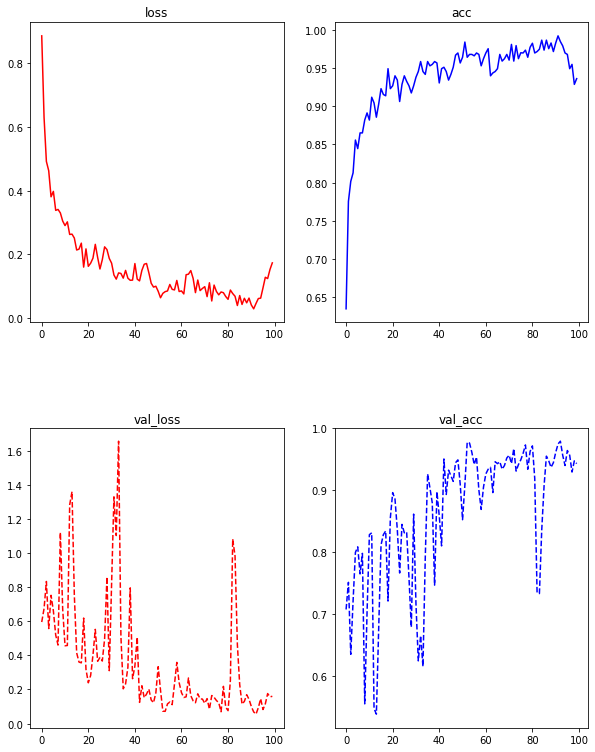

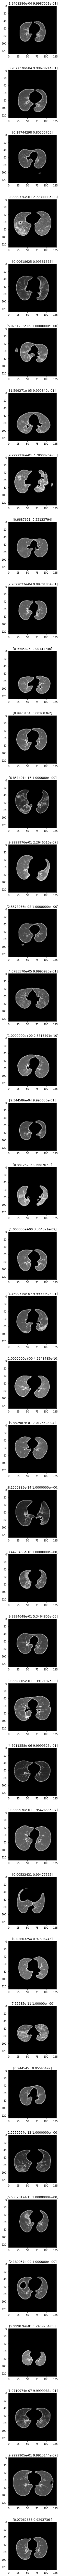

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')

preds = model.predict(xtrain)

fig1, ax1 = plt.subplots(40, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

for i in range(40):
    ax1[i].imshow(xtrain[i].squeeze())
    ax1[i].title.set_text(str(preds[i]))